# Full Wave Inversion

This tutorial shows how to developa (very idealized) Full Waveform Inversion algorithms with `jwave`. To highlight the ability of customizing the inversion algorithm, we'll add a smoothing step to the gradient computation before performing the gradient descent step with the Adam optimizer.

## Setup simulation
Let's start by importing the required modules

⚠️ Run the next cell cell if you don't have `tqdm` installed

In [2]:
!pip install tqdm

In [1]:
from functools import partial

import numpy as np
from jax import grad, jit, lax, nn
from jax import numpy as jnp
from jax import random, value_and_grad, vmap
from jax.example_libraries import optimizers
from matplotlib import pyplot as plt
from tqdm import tqdm

from jwave import FourierSeries
from jwave.acoustics import simulate_wave_propagation
from jwave.geometry import (
    Domain,
    Medium,
    Sensors,
    Sources,
    TimeAxis,
    circ_mask,
    points_on_circle,
)
from jwave.signal_processing import apply_ramp, gaussian_window, smooth

The first step is to define the simulation settings, from the geometrical properties of the domain to the sources and receivers.

In [2]:
# Settings
N = (256, 256)
dx = (0.1e-3, 0.1e-3)
cfl = 0.25
num_sources = 64
source_freq = 1e6
source_mag = 1.3e-5
random_seed = random.PRNGKey(42)

# Define domain
domain = Domain(N, dx)

# Define medium
sound_speed = jnp.ones(N)
circle_1 = circ_mask(N, 16, (100, 100))
circle_2 = circ_mask(N, 20, (165, 128))
circle_3 = circ_mask(N, 40, (130, 130))
sound_speed = sound_speed + 0.05 * circle_1 + 0.02 * circle_2 + 0.03 * circle_3
sound_speed = sound_speed * 1480
sound_speed = FourierSeries(jnp.expand_dims(sound_speed, -1), domain)

medium = Medium(domain=domain, sound_speed=sound_speed, pml_size=20.0)

# Time axis
time_axis = TimeAxis.from_medium(medium, cfl=cfl)

# Sources
source_mag = source_mag / time_axis.dt
t = time_axis.to_array()
s1 = source_mag * jnp.sin(2 * jnp.pi * source_freq * t)
signal = gaussian_window(apply_ramp(s1, time_axis.dt, source_freq), t, 3e-6, 1.2e-6)
x, y = points_on_circle(num_sources, 100, (128, 128))
source_positions = (jnp.array(x), jnp.array(y))

# Sensors
sensors_positions = (x, y)
sensors = Sensors(positions=sensors_positions)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Let's visualize the simulation settings to get a better understanding of the setup:

Text(0.5, 1.0, 'Source signals')

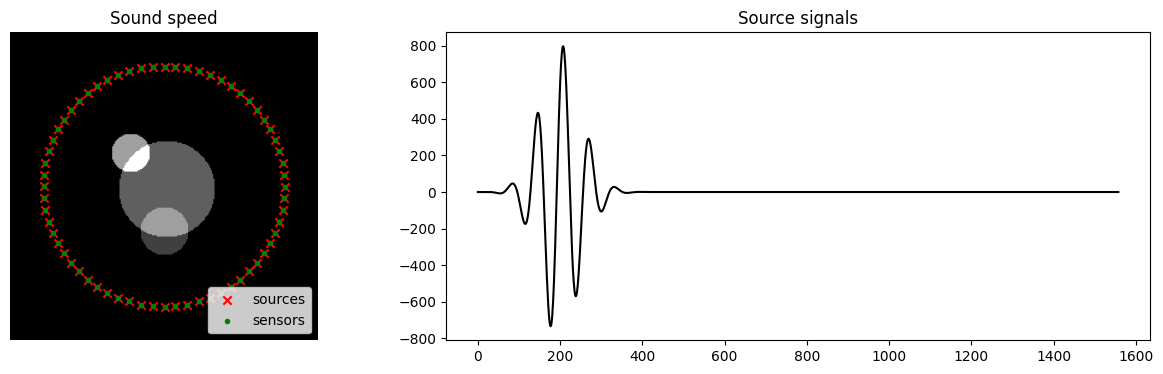

In [3]:
# Show simulation setup
fig, ax = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={"width_ratios": [1, 2]})

ax[0].imshow(medium.sound_speed.on_grid, cmap="gray")
ax[0].scatter(
    source_positions[1], source_positions[0], c="r", marker="x", label="sources"
)
ax[0].scatter(
    sensors_positions[1], sensors_positions[0], c="g", marker=".", label="sensors"
)
ax[0].legend(loc="lower right")
ax[0].set_title("Sound speed")
ax[0].axis("off")

ax[1].plot(signal, label="Source 1", c="k")
ax[1].set_title("Source signals")
#ax[1].get_yaxis().set_visible(False)

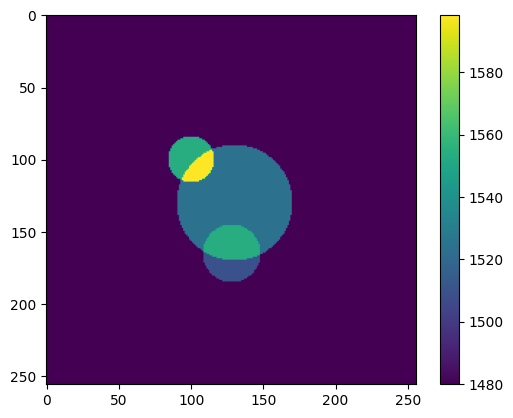

In [4]:
plt.imshow(medium.sound_speed.on_grid)
plt.colorbar()

## Run the simulation

At this point, we can finally use the `simulate_wave_propagation` to compute the wave propagation, with the given sound speed map and a pulse transmitted from the requested sensor.

In [5]:
src_signal = jnp.stack([signal])

# We can compile the entire function! All the constructors
# that don't depend on the inputs will be statically compiled
# and run only once.
@jit
def single_source_simulation(sound_speed, source_num):
    # Setting source
    x = lax.dynamic_slice(source_positions[0], (source_num,), (1,))
    y = lax.dynamic_slice(source_positions[1], (source_num,), (1,))
    sources = Sources((x, y), src_signal, dt=time_axis.dt, domain=domain)

    # Updating medium with the input speed of sound map
    medium = Medium(domain=domain, sound_speed=sound_speed, pml_size=20)

    # Run simulations
    rf_signals = simulate_wave_propagation(
        medium, time_axis, sources=sources, sensors=sensors, checkpoint=True
    )
    return rf_signals[..., 0]

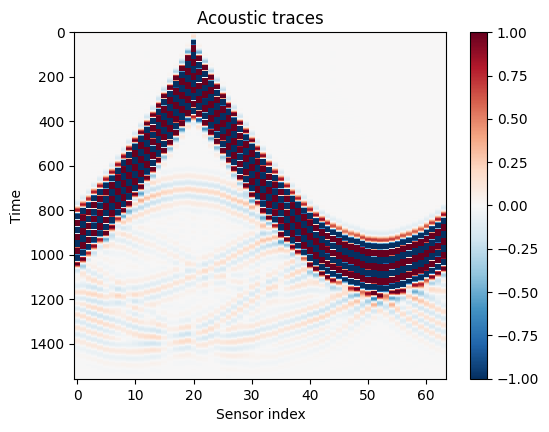

In [6]:
p = single_source_simulation(medium.sound_speed, 20)

# Visualize the acoustic traces
plt.figure(figsize=(6, 4.5))
maxval = jnp.amax(jnp.abs(p))
plt.imshow(
    p, cmap="RdBu_r", vmin=-1, vmax=1, interpolation="nearest", aspect="auto"
)
plt.colorbar()
plt.title("Acoustic traces")
plt.xlabel("Sensor index")
plt.ylabel("Time")
plt.show()

In [9]:
%%timeit
single_source_simulation(medium.sound_speed, 1).block_until_ready()

268 ms ± 195 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Because we can apply arbitrary function transformations on the simulation code, we can use `vmap` to efficiently parallelize the simulation for all sources. We'll use it as a fast method to generate all the snapshots used as data.

In [10]:
batch_simulations = vmap(single_source_simulation, in_axes=(None, 0))
p_data = batch_simulations(medium.sound_speed, jnp.arange(num_sources))
print(f"Size of data [Source idx, Time, Sensor idx]: {p_data.shape}")

Size of data [Source idx, Time, Sensor idx]: (64, 1558, 64)


Note that the execution time is smaller than 32$\times$ the single source simulation runtime

In [54]:
%%timeit
batch_simulations(medium.sound_speed, jnp.arange(num_sources)).block_until_ready()

6.57 s ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


At last, let's add some coloured noise to the data that we'll use for inversion.

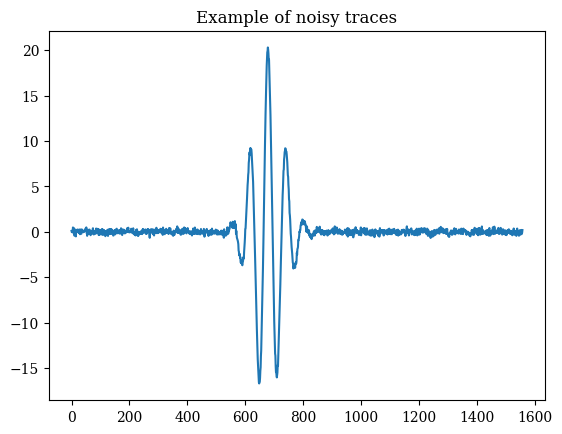

In [11]:
p_data = batch_simulations(medium.sound_speed, jnp.arange(num_sources))
noise = np.random.normal(size=p_data.shape) * 0.2
noise = jnp.fft.fft(noise, axis=1)
#noise = noise.at[:, 100:-100].set(0.0)
noise = jnp.fft.ifft(noise, axis=1).real
p_data = p_data + noise

plt.plot(p_data[12, :, 0])
plt.title("Example of noisy traces")
plt.show()

## Define the optimization problem

We'll let `autodiff` generate the full wave inversion algorithm. To do so, we need to specify a forward model that maps the speed of sound map to the acoustic data. 

While this has already be done in the previous cells of this notebook, we'll wrap it around a new function used to reparametrize the speed of sound map. This is done because the forward simulation is unstable for speed of sound values below a certain treshold $T$. To make sure that such maps are not in the range of the inversion algorithm, the speed of sound map is parametrized as
$$
c = T + \text{sigmoid}(c')
$$

Also, we'll mask the pixels outside the circle defined by the sensors, since we know that the only unknowns are the pixel values inside of it.

Lastly, we also define a handy initialization function that defines a over-smoothed version of the true sound speed map as initial guess

In [12]:
from jaxdf.operators import compose

mask = circ_mask(domain.N, 80, (128, 128))
mask = FourierSeries(jnp.expand_dims(mask, -1), domain)

def get_sound_speed(params):
    return 1480.0 + 150.0*compose(params)(nn.sigmoid) * mask

params = medium.sound_speed * 0.0 - 4

Lastly, let's define the loss function. We'll use the standard MSE loss on the residual. We then use the decorator `value_and_grad` to transform the function into one that returns the original output *and* the gradient with respect to the first input

In [13]:
from jwave.signal_processing import analytic_signal
from jaxdf.operators import gradient, functional

def hilbert_transf(signal, noise=0.2):
    x = jnp.abs(analytic_signal(signal))
    return x

def loss_func(params, source_num):
    c0 = get_sound_speed(params)
    p = single_source_simulation(c0, source_num)
    data = p_data[source_num]
    return jnp.mean(jnp.abs(hilbert_transf(p) -hilbert_transf(data)) ** 2)

loss_with_grad = value_and_grad(loss_func, argnums=0)

Let's visualize an example of the speed of sound gradient for a given source

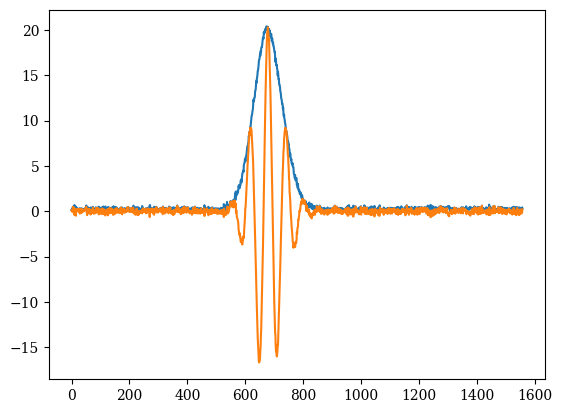

In [14]:
plt.plot(hilbert_transf(p_data[12, :, 0]))
plt.plot(p_data[12, :, 0])
plt.show()

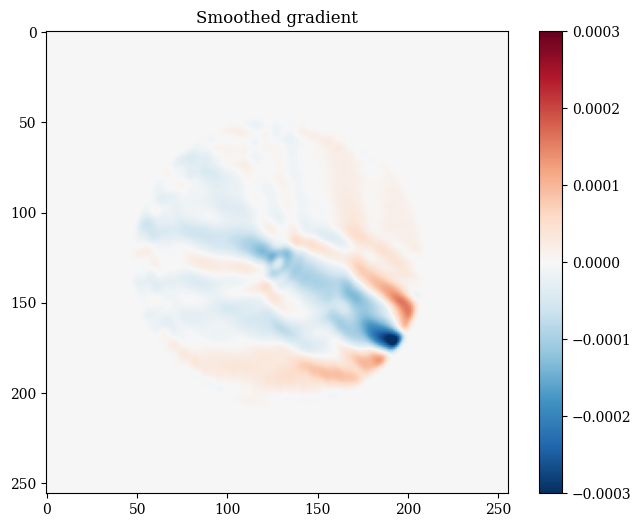

In [15]:
def smooth_fun(gradient):
    x = gradient.on_grid[..., 0]
    for _ in range(3):
        x = smooth(x)
    return gradient.replace_params(jnp.expand_dims(x, -1))*6

loss, gradient = loss_with_grad(params, source_num=10)
gradient = smooth_fun(gradient)

# Viualize
plt.figure(figsize=(8, 6))
plt.imshow(gradient.on_grid, cmap="RdBu_r", vmin=-0.0003, vmax=0.0003)
plt.title("Smoothed gradient")
plt.colorbar()
plt.show()

### Minimize the objective function

Equipped with a function that calculates the correct gradients, we can finally run the FWI algorithm by randomly looping trough the sources and update the speed of sound estimate.

Following the spirit of `JAX`, all that is needed to do is to write an `update` function that calculates the gradients and applies a step of the optimization algorithm (but we could have used full batch methods, such as BFGS). In this function, we'll also smooth the gradients: this is not necessarily a smart thing to do, but we use it here to highlight how the user can customize any step of the algorithms developed using `jwave`.

In [16]:
losshistory = []
reconstructions = []
num_steps = 100

# Define optimizer
init_fun, update_fun, get_params = optimizers.adam(0.1, 0.9, 0.9)
opt_state = init_fun(params)

# Define and compile the update function
@jit
def update(opt_state, key, k):
    v = get_params(opt_state)
    src_num = random.choice(key, num_sources)
    lossval, gradient = loss_with_grad(v, src_num)
    gradient = smooth_fun(gradient)
    return lossval, update_fun(k, gradient, opt_state)


# Main loop
pbar = tqdm(range(num_steps))
_, key = random.split(random_seed)
for k in pbar:
    _, key = random.split(key)
    lossval, opt_state = update(opt_state, key, k)

    ## For logging
    new_params = get_params(opt_state)
    reconstructions.append(get_sound_speed(new_params).on_grid)
    losshistory.append(lossval)
    pbar.set_description("Loss: {}".format(lossval))

Loss: 0.049446240067481995: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:48<00:00,  1.09s/it]


Finally, let's look at the reconstructed image and its evolution during the optimization

In [17]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

/tmp/ipykernel_861312/10384555.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


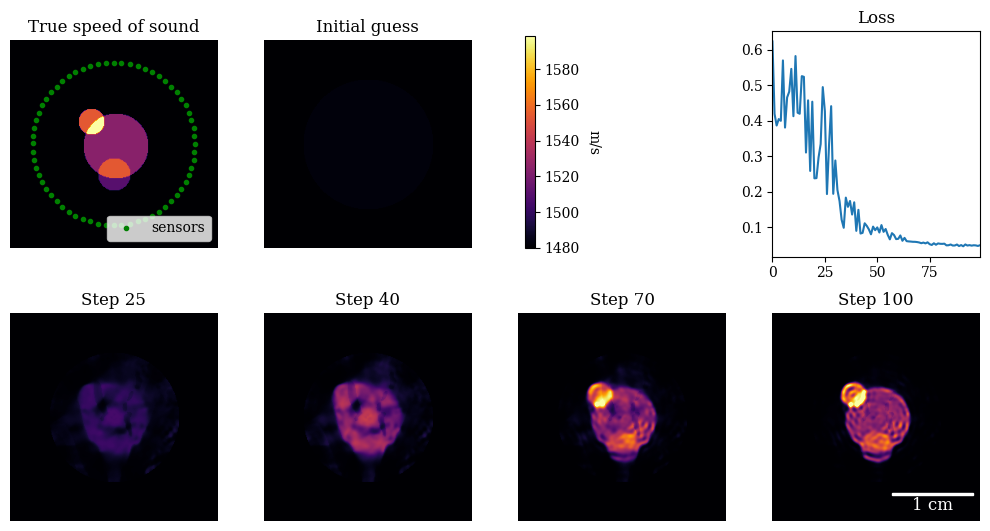

In [25]:
sos_original = get_sound_speed(params).on_grid
true_sos = sound_speed.on_grid
vmin = np.amin(true_sos)
vmax = np.amax(true_sos)

fig, axes = plt.subplots(2, 4, figsize=(10, 5.5))

k = 0
recs = [24, 39, 69, 99]
for row in range(2):
    for col in range(4):
        if k == 0:
            axes[row, col].imshow(true_sos, cmap="inferno", vmin=vmin, vmax=vmax)
            axes[row, col].scatter(
                sensors_positions[1],
                sensors_positions[0],
                c="g",
                marker=".",
                label="sensors",
            )
            axes[row, col].legend(loc="lower right")
            axes[row, col].set_title("True speed of sound")
            axes[row, col].set_axis_off()
        elif k == 1:
            im_original = axes[row, col].imshow(sos_original, cmap="inferno", vmin=vmin, vmax=vmax)
            axes[row, col].set_axis_off()
            axes[row, col].set_title("Initial guess")
            
            cbar_ax = fig.add_axes([0.53, 0.54, 0.01, 0.385])
            cbar = plt.colorbar(im_original, cax=cbar_ax)
            cbar.ax.get_yaxis().labelpad = 15
            cbar.ax.set_ylabel('m/s', rotation=270)
        elif k == 2:
            axes[row, col].set_axis_off()
        elif k == 3:
            axes[row, col].plot(losshistory)
            axes[row, col].set_title("Loss")
            #axes[row, col].set_xticks([], [])
            axes[row, col].margins(x=0)
        else:
            axes[row, col].imshow(reconstructions[recs[k - 4]], cmap="inferno", vmin=vmin, vmax=vmax)
            axes[row, col].set_axis_off()
            axes[row, col].set_title("Step {}".format(recs[k - 4] + 1))
        k += 1

# Scale bar
fontprops = fm.FontProperties(size=12)
scalebar = AnchoredSizeBar(
    axes[-1, -1].transData,
    100, '1 cm', 'lower right', 
    pad=0.3,
    color='white',
    frameon=False,
    size_vertical=2,
    fontproperties=fontprops)
axes[-1, -1].add_artist(scalebar)
        
fig.tight_layout()

plt.savefig('fwi.pdf')

#### Note

This notebook is only intended to highlight the ability to take gradients using a [discretize-then-optimize](https://arxiv.org/abs/2005.13420)  approach (see also [[Burstedde  2009]](https://ins.uni-bonn.de/media/public/publication-media/BursteddeGhattas09.pdf?pk=572), [[Guidio 2021]](https://ascelibrary.org/doi/full/10.1061/%28ASCE%29EM.1943-7889.0001909) and [[Rackauckas 2021]](https://arxiv.org/abs/2001.04385).

We are also guilty of committing the [inverse crime](https://arxiv.org/abs/math-ph/0401050), since the same simulator has been used to both generate the data and inverting them.